In [1]:
import numpy
numpy.float = numpy.float64
numpy.int = numpy.int_
import skvideo.io

video_data = skvideo.io.vread("/Users/edeno/Downloads/1-s2.0-S0896627323005500-mmc2.mp4")


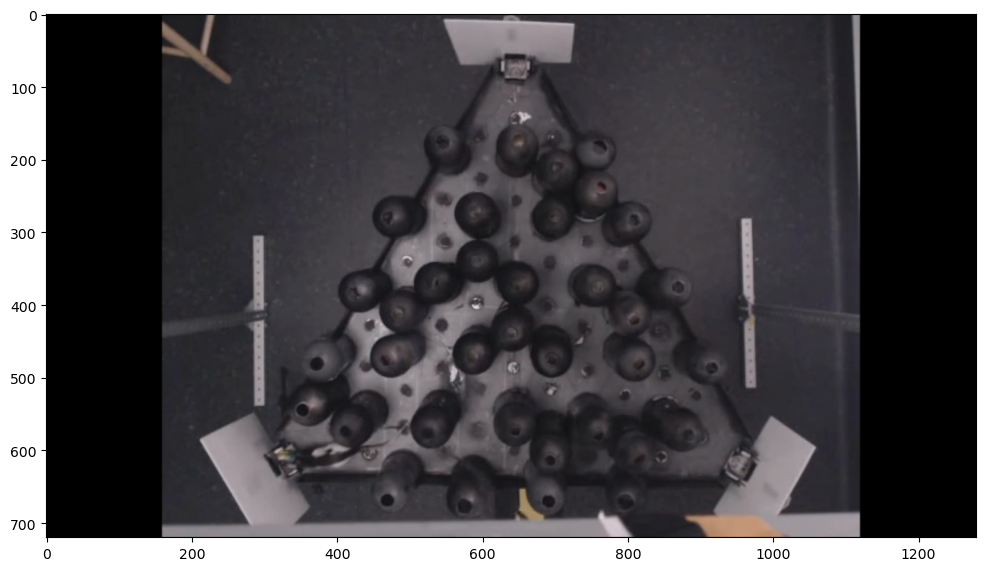

In [2]:
import matplotlib.pyplot as plt

first_frame = video_data[0]

plt.figure(figsize=(12,11))
plt.imshow(first_frame)

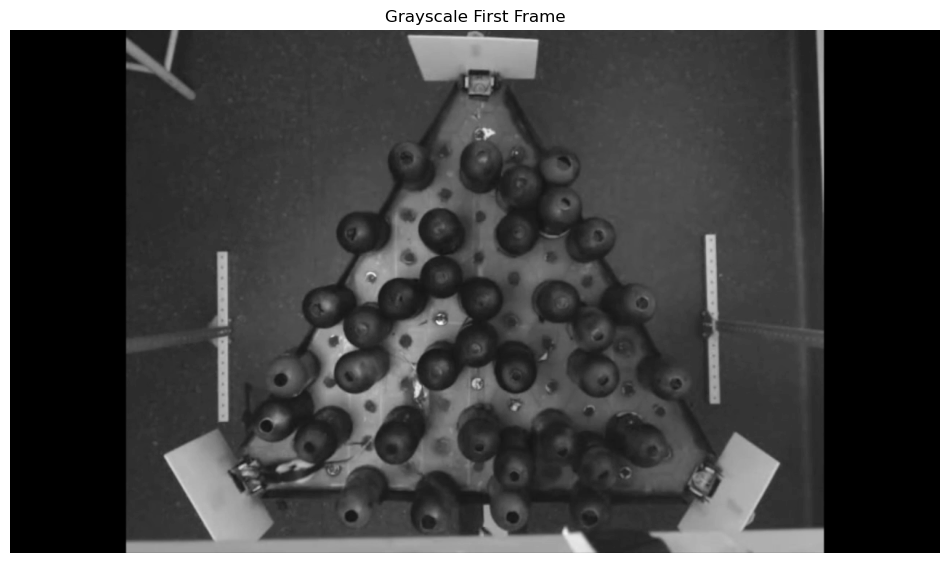

In [3]:
from skimage.color import rgb2gray

first_frame_gray = rgb2gray(first_frame)

plt.figure(figsize=(12,11))
plt.imshow(first_frame_gray, cmap='gray')
plt.title("Grayscale First Frame")
plt.axis("off")
plt.show()

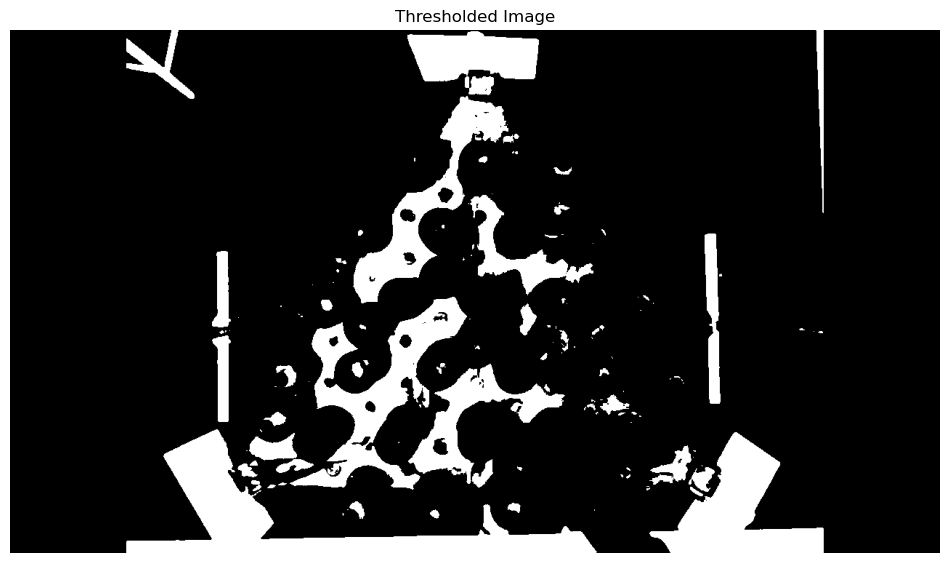

In [4]:
from skimage.filters import threshold_otsu

thresh_value = threshold_otsu(first_frame_gray)
binary = first_frame_gray > thresh_value

plt.figure(figsize=(12,11))
plt.imshow(binary, cmap='gray')
plt.title("Thresholded Image")
plt.axis("off")
plt.show()


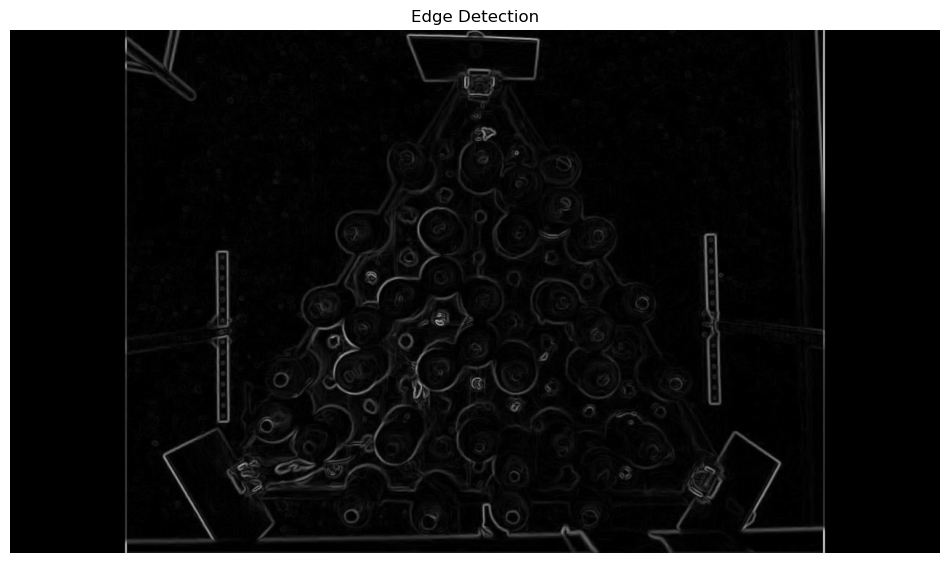

In [5]:
from skimage import filters

edges = filters.sobel(first_frame_gray)

plt.figure(figsize=(12,11))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis("off")
plt.show()


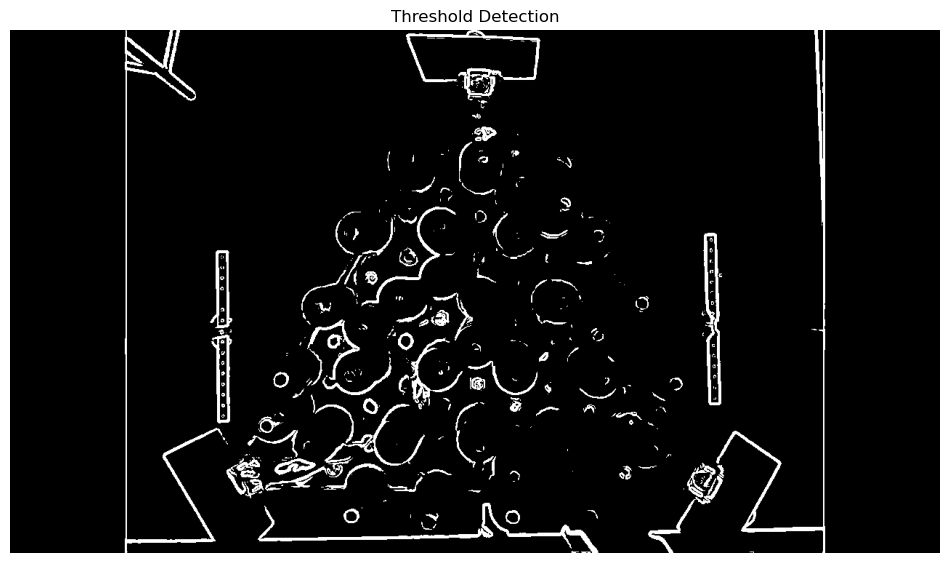

In [6]:
from skimage.filters import threshold_otsu

thresh_value = threshold_otsu(edges)
binary = edges > thresh_value

plt.figure(figsize=(12,11))
plt.imshow(binary, cmap='gray')
plt.title("Threshold Detection")
plt.axis("off")
plt.show()


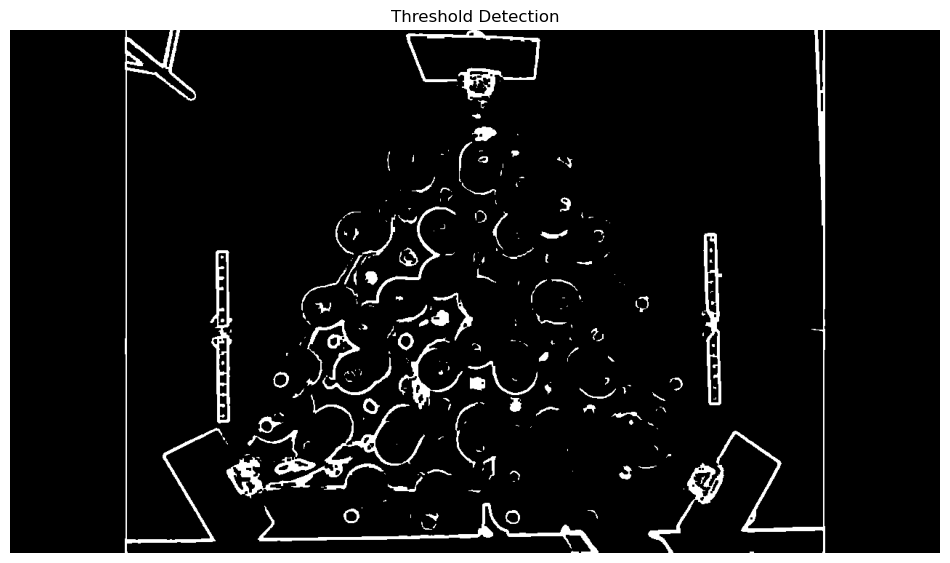

In [7]:
from skimage.morphology import dilation, erosion, square

dilated = dilation(binary, square(3))
eroded = erosion(dilated, square(3))

plt.figure(figsize=(12,11))
plt.imshow(eroded, cmap='gray')
plt.title("Threshold Detection")
plt.axis("off")
plt.show()


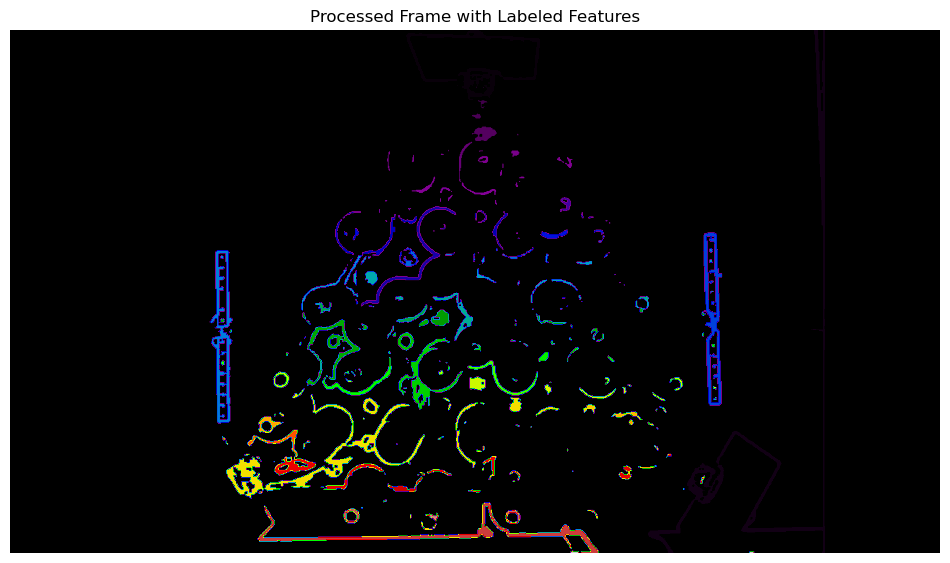

In [8]:
from skimage.measure import label

labeled = label(eroded)

plt.figure(figsize=(12,11))
plt.imshow(labeled, cmap='nipy_spectral')
plt.title("Processed Frame with Labeled Features")
plt.axis('off')
plt.show()


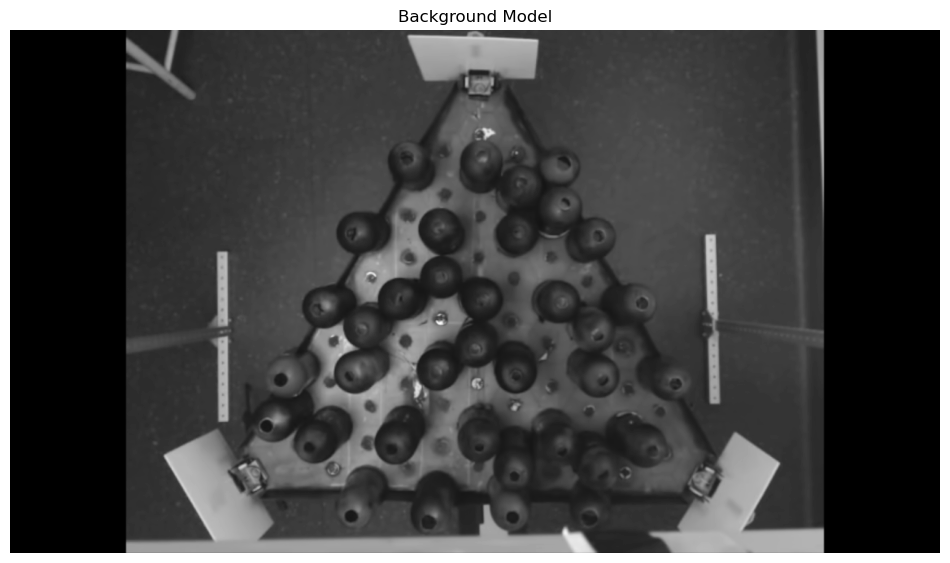

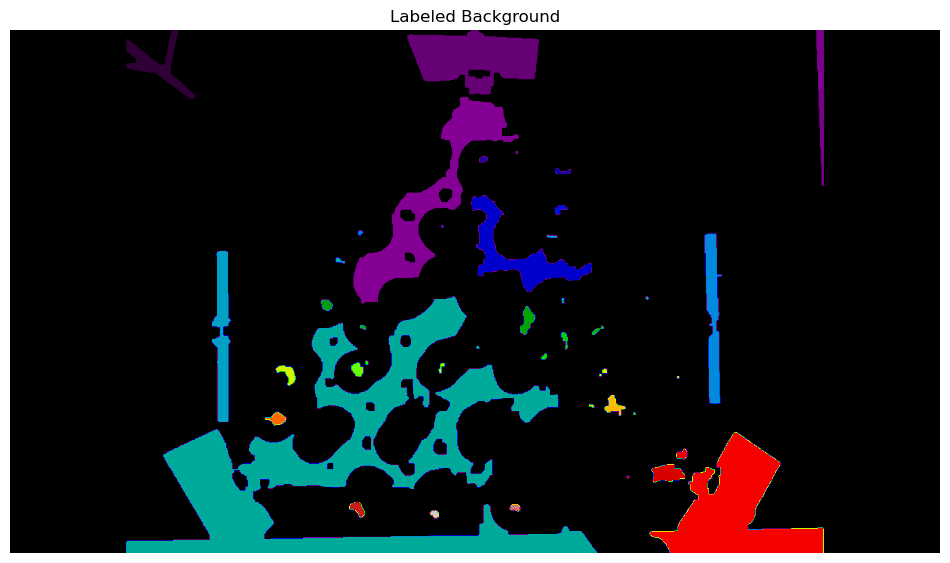

In [9]:
import numpy as np
from skimage.morphology import opening, closing
from skimage.exposure import equalize_adapthist


N = 300  # Number of frames to average for the background
background_model = np.mean(video_data, axis=0).astype(np.uint8)
background_model_gray = rgb2gray(background_model)

plt.figure(figsize=(12,11))
plt.imshow(background_model_gray, cmap='gray')
plt.title("Background Model")
plt.axis('off')
plt.show()

thresh_value = threshold_otsu(background_model_gray)
binary_background = background_model_gray > thresh_value
cleaned_background = closing(opening(binary_background, square(3)), square(7))
labeled_background = label(cleaned_background)


plt.figure(figsize=(12,11))
plt.imshow(labeled_background, cmap='nipy_spectral')
plt.title("Labeled Background")
plt.axis('off')
plt.show()




In [10]:
import jax.numpy as jnp
import jax
from flax import linen as nn
import optax

class Autoencoder(nn.Module):
    def encode(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))(x)
        return nn.relu(x)

    def decode(self, z):
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))(z)
        z = nn.relu(z)
        z = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))(z)
        return nn.sigmoid(z)

    def __call__(self, x):
        z = self.encode(x)
        return self.decode(z)


In [13]:
video_frames = video_data / jnp.max(video_data)
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def setup(self):
        self.encoder = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))
        self.encoder2 = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))
        self.decoder = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))
        self.decoder2 = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))

    def encode(self, x):
        x = self.encoder(x)
        x = nn.relu(x)
        x = self.encoder2(x)
        return nn.relu(x)

    def decode(self, z):
        z = self.decoder(z)
        z = nn.relu(z)
        z = self.decoder2(z)
        return nn.sigmoid(z)

    def __call__(self, x):
        z = self.encode(x)
        return self.decode(z)

# Initialize the Autoencoder model and optimizer
model = Autoencoder()
params = model.init(jax.random.PRNGKey(0), video_frames[:1, :, :, :])
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

def get_batches(video_frames, batch_size=8):
    num_frames = video_frames.shape[0]
    for i in range(0, num_frames, batch_size):
        yield video_frames[i:i + batch_size]

# Training function
@jax.jit
def train_step(params, opt_state, batch):
    def mse_loss(params, batch):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction)**2)

    grad = jax.grad(mse_loss)(params, batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# Training loop with batches
batch_size = 8
epochs = 50
for epoch in range(epochs):
    for batch in get_batches(video_frames, batch_size):
        params, opt_state = train_step(params, opt_state, batch)
    
    # Evaluate loss on the full dataset for monitoring
    full_dataset_loss = jnp.mean((video_frames - model.apply(params, video_frames)) ** 2)
    print(f"Epoch {epoch + 1}, Loss: {full_dataset_loss}")

# Applying the trained Autoencoder to encode video_frames
encoded_frames = model.encode(video_frames).block_until_ready()